# The surface class
In this notebook we will look at all the functionality in the surface class. We will cover:

- Making a surface from an array
- Falttenting the surface by subtracting a polynomial
- Setting the extent, grid spacing and shape of a surface
- Measuring the roughness of a surface, with and without a mask
- Finding the FFT, PSD and ACF of a surface
- Plotting a surface
- Combining surfaces 
- Resampling the surface on a different grid
- Getting the X and Y grid points of a surface
- Some of the important properties of a surface

There are more detailed notebooks for geometric surfaces, random surfaces and opening surfaces from files this is meant to be a general introduction to the base functionality in the surface class.

The surface class is in the surface sub package, we need to import this package before we can use anything in it, for brevity we will import it as S, this line may take a while to run as it executes all the code in the surface sub package. We will also import numpy so we can use arrays and random functions.

In [1]:
import numpy as np
import slippy.surface as S

## Making a surface from an array

Now let's make a surface, the simplest way to do this is to start with an array and convert it. However, many other methods are supported and the used is directed to the examples on reading surfaces, generating random surfaces, and making analytical geometric surfaces for more information.

In this example we will make a surface of a double sin function:

In [2]:
# making the surface profile
x, y = np.linspace(0,2*np.pi, 128), np.linspace(0,2*np.pi, 128)
X, Y = np.meshgrid(x,y)
Z = 2*np.sin(2*X) + np.sin(4*Y)
# making a surface from the profile
my_array_surface = S.assurface(Z)

## Acessing the profile, size and shape properties

We can look at the profile of the surface by accesing the .profile property of the object we just created. 

It is also compatible with numpy functions directly, any funciton that takes an 'array-like' input will work with surface objects, but the output will be a numpy array (c array):

In [3]:
# accesing the profile of the surface
print('Acessing the .profile property of the surface:')
print(type(my_array_surface.profile), my_array_surface.profile.shape)
print('Using the surface directly with numpy functions:')
print(np.clip(my_array_surface, 0,1))

Acessing the .profile property of the surface:
<class 'numpy.ndarray'> (128, 128)
Using the surface directly with numpy functions:
[[0.         0.19757284 0.39321288 ... 0.         0.         0.        ]
 [0.19660644 0.39417928 0.58981932 ... 0.         0.         0.19660644]
 [0.38553834 0.58311118 0.77875122 ... 0.         0.18796551 0.38553834]
 ...
 [0.         0.         0.00767454 ... 0.         0.         0.        ]
 [0.         0.0009664  0.19660644 ... 0.         0.         0.        ]
 [0.         0.19757284 0.39321288 ... 0.         0.         0.        ]]


Some properties of the surface have already been set, it's shape (the number of points in each direction), it's size (the total number of points), and the fact that it is descrete and not analytical:

In [4]:
print('Surface shape is: ', my_array_surface.shape)
print('Surface size is: ', my_array_surface.size)
print('The surface is represented by a descrete set of points: ', my_array_surface.is_descrete)
print('The surface is anayltical: ', my_array_surface.is_analytic)

Surface shape is:  (128, 128)
Surface size is:  16384
The surface is represented by a descrete set of points:  True
The surface is anayltical:  False


## Shape, extent, grid_spacing

However, the overall dimetions of the surface (the extent) are not known as the distance between the grid points (the grid_spacing) is not known. We can set either of these directly. It is recomended to set the grid spacing rather than the extent. It should be clear that the grid spacing, the extent and the shape of the surface are related: setting any two of these will automatically set the other one, setting more than 2 of these will result in an error.

In [5]:
my_array_surface.grid_spacing = x[1]-x[0]
print('The overall dimentions of the surface are: ', my_array_surface.extent)
print('The distanct between grid points is: ', my_array_surface.grid_spacing)
print('The number of grid points in each direction is: ', my_array_surface.shape)
print('Trying to set the shape when there is a profile present will result in an error:')
try:
    my_array_surface.shape = (100,100)
except ValueError:
    print('Causes an error!')

The overall dimentions of the surface are:  (6.3326592072361185, 6.3326592072361185)
The distanct between grid points is:  0.049473900056532176
The number of grid points in each direction is:  (128, 128)
Trying to set the shape when there is a profile present will result in an error:
Causes an error!


# Flattening a surface by subtracting a polynomial
Often, surfaces that have been read in using measurment machines will be slanted or curved in a way that is not ideal for analysis. While the roughness measurment functions will deal with this automatically it is useful to be able to do this manually too. A polynomial of any degree can be subtracted from a surface using the subtract_polynomial method. This method also returns the coeficents of the fitted polynimial.

This method can also be used with a binary mask, this should be a binary array of the same shape as the surface profile with 1's at the elements to be used in the fitting and 0's at the elements to be ignored by the fitting. Alternatively the mask can also be a float (eg. float('nan') or float('inf')), in that case any elements in the surface equal to the float value will be ignored. This mask should be passed in as the second argument:

In [6]:
# subtract a quadratic polynomial from the surface:
coefs = my_array_surface.subtract_polynomial(2)
print(coefs)

[ 1.16445207e+00 -3.66036873e-03 -2.67995870e-15 -1.46774591e-02
 -2.88768992e-15  1.02953557e-17 -2.65490283e-15  1.21994858e-17
  2.32130528e-19]


As expected this surface is already very flat.

## Measuring the roughness of the surface

There are many roughness functions avalible in the surface class. These are aliased from the slippy.surface.roughness function so any of the parameters measured by that function are avaliable.

The names of the roughness parametes can be passed indivdually or as a list, there are also other parameters which can be set to control how the fucntion runs:
- mask, the same as the mask for the subtract_polynomial funciton
- curved_surface, if True a quadratic polynomial is subtracted otherwise a linear polynimial is subtracted. This deafaults to False
- no_flattening, if True No polynomial is subtracted before calculating the roughness paramter, this defaults to False
- filter_cut_off, is set the surface will be low pass filtered before finding summits, this dosn't effect the surface profile, this defaults to None, maening no filtering will be used
- four_nearest, if True a point is designated a summit if it is higher than it's four nearest neigbours, otherwise it must be higher than it's 8 nearest neigbours, this defaults to False

In [7]:
print('Getting a sinle parameter:')
sa = my_array_surface.roughness('sa', no_flattening = True)
print('Mean absolute height is: ', sa)
print('\nGetting multiple parameters:')
rou = my_array_surface.roughness(['sa', 'sq', 'ssk', 'sku'], no_flattening = True)
nam = ['Mean abs height: ', 'Root mean square height: ', 'Skew: ', 'Kurtosis: ']
for n,r in zip(nam, rou):
    print(n, r)

Getting a sinle parameter:
Mean absolute height is:  1.2243697691300202

Getting multiple parameters:
Mean abs height:  1.2243697691300202
Root mean square height:  1.4724346873863143
Skew:  9.396678215859124e-11
Kurtosis:  2.263107754395294


## FFT ACF and PSD of a surface
The fft, psd and acf of a surface can be found by using the get_*** method for the desired property, such as get_fft. The result is set as an attribute of the surface object:

In [8]:
print('Surface has no acf:', my_array_surface.acf)
print('Finding acf..')
my_array_surface.get_acf()
print('The acf is now accesable:', my_array_surface.acf)

Surface has no acf: None
Finding acf..
The acf is now accesable: <slippy.surface.ACF_class.ACF object at 0x000001760A55F550>


There are identical fucntions for the fft and psd: get_fft and get_psd, the results are set as the .fft and .psd attributes.

## Plotting a Surface
There are many options available for plotting a surface object or it's properties. The show function can be used to plot a surface, it defaults to a surface plot of the profile.

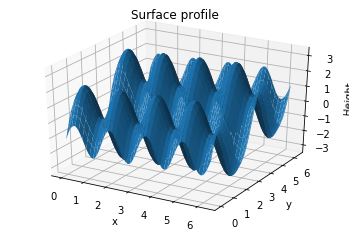

In [9]:
my_array_surface.show()

But it can handle a veriety of different plot types and parameters, if these are given in a sequence the result is a single figure containing multiple plots:

C:\Users\44779\code\slippy\surface\Surface_class.py:940: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


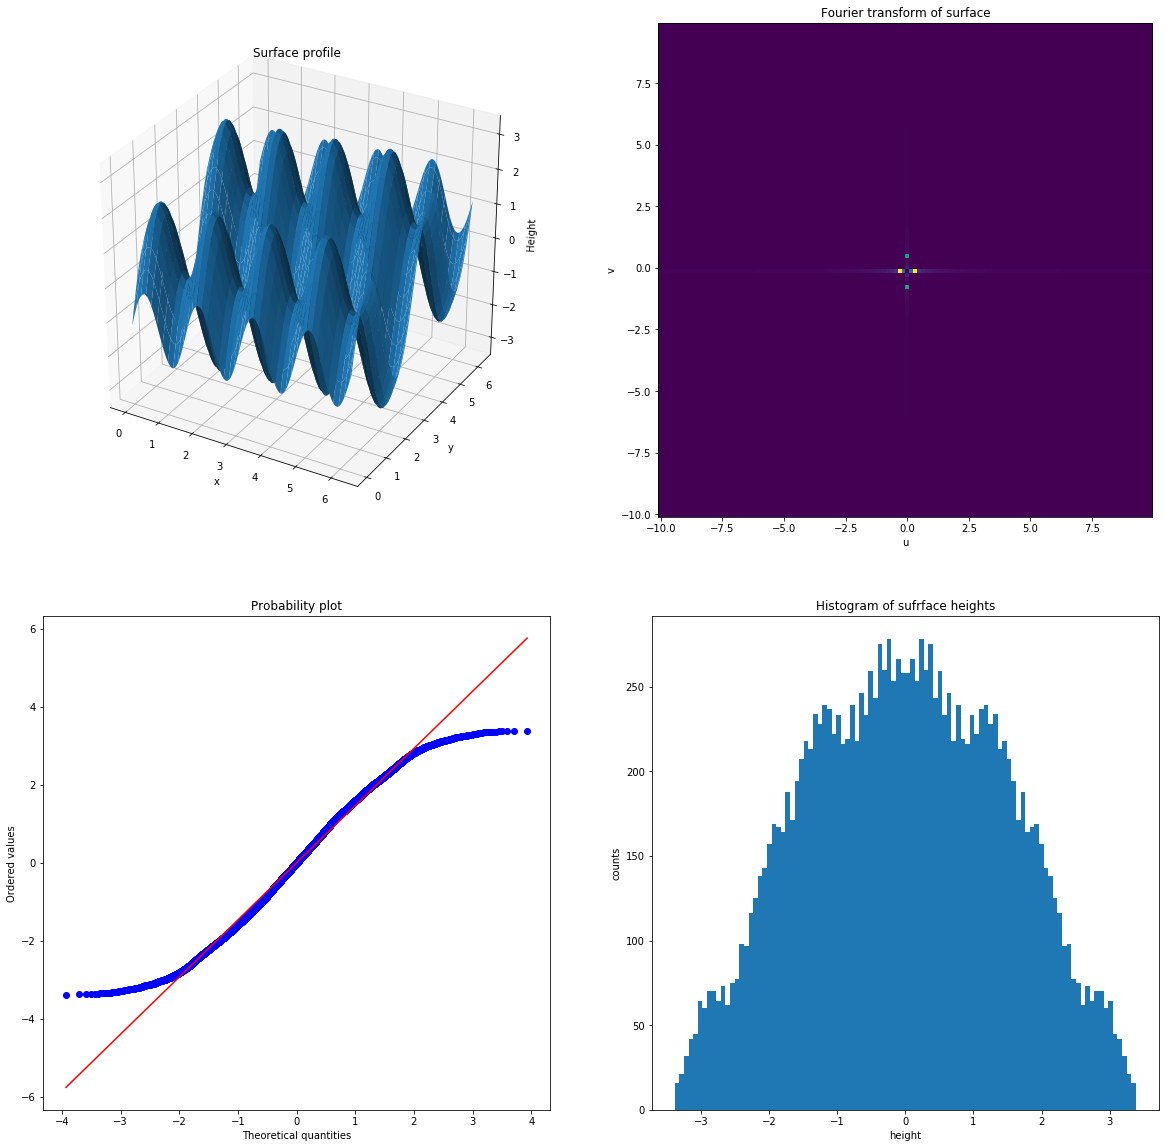

In [10]:
fig, ax = my_array_surface.show(['profile', 'fft2d', 'QQ', 'histogram'], ['default', 'image', 'default'], figsize=(20,20))

Above we have plotted the surface profile, the FFT of the surface as an image, a QQ plot comparing the surface heights to a normal distribution, and a histogram of the surface heights. The figure handle and the axes handels are returned by the show method which allows the user to further customise the plots. The plotting is based on the matplotlib library and the user should look at the documentation for that library for furtheer information on customising plots.

## Combining surfaces
Surfaces can be added or subtracted from each other, if they have the same grid spacing then the result from the overlapping area is returned, if they do not have the same grid spacing then the one with the coarser grid is interpolated on the finer grid before adding or subtracting, this produces a warning.

In [11]:
# Adding surfaces with the same grid_spacing and shape:
print('Same grid spacing and shape:')
same_shape_gs = S.assurface(Z*0.1, grid_spacing = my_array_surface.grid_spacing)
new_surface = same_shape_gs + my_array_surface
print('GS on new surface is the same as original: ', new_surface.grid_spacing == my_array_surface.grid_spacing, 
      '\nShape same on new and original surfaces: ', new_surface.shape == my_array_surface.shape)
# Adding surfaces with different shapes but the same grid_spacing (only overlap added):
print('\nSame grid spacing, different shape:')
smaller_surface = S.assurface(-1*Z[:-1,:-1])
new_surface = my_array_surface + smaller_surface
print('GS is the same on the new surface as the original: ', new_surface.grid_spacing == my_array_surface.grid_spacing,
      '\nShape is as large as the overlap between the surfaces: ', new_surface.shape)
# Adding different shape surfaces with different grid spacings:
print('\nAdding different shape surfaces with different grid spacings:')
coarser_surface = S.assurface(Z, grid_spacing = my_array_surface.grid_spacing*2)
new_surface = my_array_surface + coarser_surface
print('New surface keeps finer grid spacing: ', new_surface.grid_spacing==my_array_surface.grid_spacing)
print('New surface has same extent as the overlap: ', new_surface.extent==my_array_surface.extent)

Same grid spacing and shape:
GS on new surface is the same as original:  True 
Shape same on new and original surfaces:  True

Same grid spacing, different shape:
GS is the same on the new surface as the original:  True 
Shape is as large as the overlap between the surfaces:  (127, 127)

Adding different shape surfaces with different grid spacings:
New surface keeps finer grid spacing:  True
New surface has same extent as the overlap:  True


## Resampling surfaces on a different grid
This adding behaviour implies that there is a method to interpolate surfaces on a different grid. The resample method allows the user to acces this functionality.

This method creates a cubic spline interpolation of the original surface, this is then used to resample the surface on the desired grid. Making the interpolation funcitons is costly, so the result is memoized meaning that subsequent calls will be much faster than the first call. This also means that further calls to the resample function will not result in a loss of accuracy. For example the surface can be resampled over a rough grid then the original surface can be recoverd by sampling over the original grid.

In [18]:
original_gs = my_array_surface.grid_spacing
original_profile = my_array_surface.profile
print('Original surface: gs = ', my_array_surface.grid_spacing, ' shape = ', my_array_surface.shape)
my_array_surface.resample(original_gs*1.5)
print('Resampled surface: gs = ', my_array_surface.grid_spacing, ' shape = ', my_array_surface.shape)
my_array_surface.resample(original_gs)
print('Has the original profile been recoverd: ', all((my_array_surface.profile == original_profile).flatten()))


Original surface: gs =  0.049473900056532176  shape =  (128, 128)
Resampled surface: gs =  0.07421085008479826  shape =  (86, 86)
Has the original profile been recoverd:  True


## Getting the grid points of a surface in the x and y directions
While the surface profile represents the loaction of the grid points in the z direciton, the loactions of each grip point in the x and y directions can be recoverd by calling the get_points_from_extent method with no arguments. 

Alternatively this method can be used to give the x and y points the result from a combination of any two of: grid_spacing, extent and shape. If any two of the arguments are set this method will return the x and y points that would result. If only one or all three are set it will raise an error.

In [19]:
X_mesh, Y_mesh = my_array_surface.get_points_from_extent()